Just a first draft, delete, modify as you want 

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import pickle
import gc

from helpers.readers import prepare_dataframes, read_dataframe_parquet
from helpers.readers import save_parquet_to_generated, save_dict_to_generated, load_dict_from_generated
from helpers.utils import PALETTE_D, PALETTE_C

# Loading dataframes

In [2]:
movies = read_dataframe_parquet("merged/movies")
directors = read_dataframe_parquet("merged/directors")
awards = read_dataframe_parquet("merged/awards")

In [3]:
all_countries = movies["countries"]
split_countries = all_countries.str.split(',')
flat_list = [country.strip() for sublist in split_countries for country in sublist]
countries = sorted(set(flat_list))
print(f'We have movies from {len(countries)} countries in the world.')

We have movies from 143 countries in the world.


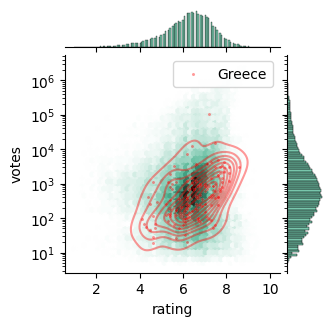

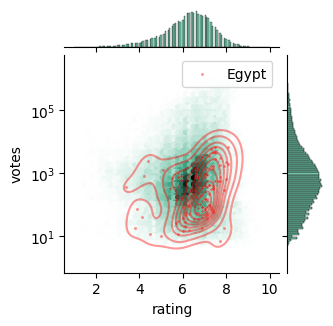

In [4]:
for country in ['Greece',"Egypt"]:#, 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    g.fig.set_figwidth(3)  
    g.fig.set_figheight(3)  
    
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

### Movie score

In [5]:
%%time

def compute_score_vectorized(df):
    df['score'] = np.log10(df['votes']) * df['rating']
    return df

movies = compute_score_vectorized(movies)

CPU times: total: 0 ns
Wall time: 2.28 ms


In [6]:
def list_top_movies(country: str, top=5):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])
    
list_top_movies('Iran')

,title,score,rating,votes,revenue,release,genres
tconst,,,,,,,
tt1832382,A Separation,44.848721,8.3,253198.0,NaN,2011,Drama
tt0118849,Children of Heaven,40.132846,8.2,78388.0,1628579.0,1997,"Family Film,Drama,Adventure,World cinema,Comedy"
tt1360860,About Elly,37.510196,7.9,55992.0,1350000.0,2009,"Mystery,Drama,World cinema"
tt0416960,Marmoulak,36.448384,8.4,21832.0,NaN,2004,Comedy
tt0100234,Close-up,35.589689,8.2,21888.0,NaN,1990,"Crime Fiction,Drama,World cinema,Documentary"


### Score for directors

In [7]:
len(movies[movies["directors"].str.contains(",", na=False)]) # some movies have multiple directors

6310

In [8]:
movies_exploded = movies.reset_index(drop=False).copy()

movies_exploded['directors'] = movies_exploded['directors'].str.split(',')
movies_exploded = movies_exploded.explode('directors')

len(movies_exploded[movies_exploded["directors"].str.contains(",", na=False)]) # after explode no more duplicates

0

```python
%%time
directors.reset_index(inplace=True)


def hits_metric(data, threshold):
    return data['score'].gt(threshold).sum()

def rate_metric(data, rate_threshold, vote_threshold):
    return data[(data['rating'] >= rate_threshold) & (data['votes'] >= vote_threshold)].shape[0]

def avg_top_n_scores(data, n):
    if len(data) >= n:
        return data.nlargest(n, 'score')['score'].mean()
    return pd.NA

grouped = movies_exploded.groupby('directors')
director_metrics = pd.DataFrame(index=grouped.groups.keys())

# Calculate each metric
director_metrics['hits-30'] = grouped.apply(hits_metric, threshold=30)
director_metrics['hits-40'] = grouped.apply(hits_metric, threshold=40)
director_metrics['hits-45'] = grouped.apply(hits_metric, threshold=45)
director_metrics['hits-50'] = grouped.apply(hits_metric, threshold=50)
director_metrics['rate-7.0'] = grouped.apply(rate_metric, rate_threshold=7.0, vote_threshold=1000)
director_metrics['rate-7.5'] = grouped.apply(rate_metric, rate_threshold=7.5, vote_threshold=1000)
director_metrics['rate-8.0'] = grouped.apply(rate_metric, rate_threshold=8.0, vote_threshold=1000)
director_metrics['rate-8.5'] = grouped.apply(rate_metric, rate_threshold=8.5, vote_threshold=1000)
for n in [3, 5, 10]:
    director_metrics[f'avg-{n}'] = grouped.apply(avg_top_n_scores, n=n)

director_metrics.reset_index(inplace=True)
director_metrics.rename(columns={'index': 'nconst'}, inplace=True)

# there is probably a way to optimize even further but for now 20mins => 3mins is sufficient, would probably involve 
# a smart grouping and mapping to avoid using apply()
```

In [9]:
# shortcut to not wait 2-3 mins (to remove for final run)
directors.reset_index(inplace=True)
director_metrics = read_dataframe_parquet("directors/metrics")

In [10]:
directors_with_country = pd.merge(
    director_metrics,
    movies_exploded[['directors', 'countries']],
    left_on='nconst',
    right_on='directors',
    how='left'
)

In [11]:
# minimal version
def list_top_directors(country: str, top=5, score='avg-3'):

    directors_in_country = directors_with_country[directors_with_country['countries'].str.contains(country, na=False)]

    grouped_directors = directors_in_country.groupby('nconst').agg({score: 'mean'})

    top_directors = grouped_directors.sort_values(by=score, ascending=False).head(top)

    return top_directors#.index.tolist()

list_top_directors('Iran', top=5)

,avg-3
nconst,
nm0327944,41.949604
nm0000080,40.353561
nm1410815,37.885910
nm0000576,35.739974
nm0006498,35.496518


In [12]:
# as in scores-sepehr
def list_top_directors(country: str, top=5, score='avg-3'):
    directors_in_country = directors_with_country[directors_with_country['countries'].str.contains(country, na=False)]
    grouped_directors = directors_in_country.groupby('nconst').agg({
        'hits-30': 'mean', 
        'hits-40': 'mean', 
        'hits-45': 'mean', 
        'hits-50': 'mean', 
        'rate-7.0': 'mean', 
        'rate-7.5': 'mean', 
        'rate-8.0': 'mean', 
        'rate-8.5': 'mean', 
        'avg-3': 'mean', 
        'avg-5': 'mean', 
        'avg-10': 'mean'
    })
    top_directors = grouped_directors.sort_values(by=score, ascending=False).head(top)
    
    top_directors_detailed = pd.merge(
        top_directors,
        directors[['nconst', 'primaryName', 'birthYear', 'deathYear', 'awardsNominated', 'awardsWon']],
        on='nconst',
        how='left'
    )
    columns_order = [
        'nconst', 'primaryName', 'birthYear', 'deathYear', 'awardsNominated', 'awardsWon',
        'hits-30', 'hits-40', 'hits-45', 'hits-50', 
        'rate-7.0', 'rate-7.5', 'rate-8.0', 'rate-8.5', 
        'avg-3', 'avg-5', 'avg-10'
    ]
    top_directors_detailed = top_directors_detailed[columns_order]
    
    return top_directors_detailed

list_top_directors('Iran', top=5)

,nconst,primaryName,birthYear,deathYear,awardsNominated,awardsWon,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
0,nm0327944,Alejandro G. Iñárritu,1963,<NA>,279,122,4.0,3.0,0.0,0.0,4.0,3.0,1.0,0.0,41.949604,37.726471,NaN
1,nm0000080,Orson Welles,1915,1985,57,33,8.0,2.0,1.0,0.0,12.0,8.0,2.0,0.0,40.353561,37.559267,34.21558
2,nm1410815,Asghar Farhadi,1972,<NA>,165,86,3.0,1.0,0.0,0.0,4.0,4.0,1.0,0.0,37.885910,NaN,NaN
3,nm0000576,Sean Penn,1960,<NA>,175,73,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,35.739974,31.874882,NaN
4,nm0006498,Majid Majidi,1959,<NA>,57,39,4.0,1.0,0.0,0.0,6.0,4.0,2.0,0.0,35.496518,32.781849,NaN


In [13]:
directors = pd.merge(directors, director_metrics, left_on="nconst", right_on="nconst", how="left")

In [14]:
directors.set_index('nconst', inplace=True) # needed nconst as column for top_directors_detailed merge of list_top_directors

# Q1:  How impactful is the team surrounding the director on the success of a movie?


To answer to this question, we need additional information than what we already have in the `movies` & `directors` dataframe. Namely, the `imdb_people` and `imdb_principals` dataframe are of interest here.

- `imdb_people` contains birth/death years, primary professions and famous titles for ~12M people in the IMDb database

- `imdb_principals` contains the principal (max 10 per movie) people that have played in movies in the IMDb database (roughs out to ~58M rows)


They will thus be used to extract information about people that worked on the movies we selected. Their primary professions, the number of movies they played in, the potential nature of the roles they played in each movie (once actor, once writer, etc.)

We first retrieve 'reduce' these two dataframes to only contain information about the movies we decided to keep:

In [15]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28478 directors.


### to unmarkdown?
%%time
imdb_info = read_dataframe_parquet(name='imdb/movies')
imdb_ratings = read_dataframe_parquet(name='imdb/ratings')
movieLens_movies = read_dataframe_parquet(name='movieLens/movies')
movieLens_ratings = read_dataframe_parquet('movieLens/ratings')

imdb_crew = read_dataframe_parquet(name='imdb/crew')
imdb_people = read_dataframe_parquet(name='imdb/names')
imdb_principals = read_dataframe_parquet(name='imdb/principals')

#directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
#directors = directors.set_index('nconst')

```python
def matching_selected_people(imdb_people,imdb_principals,movies) : 

    """
    This function filters the IMDb dataframes for people that worked on the selected movies.

    Args :
        imdb_people : The IMDb 'basic' dataframe. Contains information about people, f.i the movies they are known most for.
        imdb_principals : The IMDb 'principals' dataframe. Contains information about the main cast of the IMDb movies, such as their name, job in the movie, role, etc.
        movies : The dataset of selected movies

    Returns :
        matched_imdb_people : The IMDb 'basic' dataframe matched for our selected movies
        jobs_principal_people : The IMDb 'principals' dataframe matched for our selected movies.
    """

    #Exploding the imdb people dataframe to have all films played by people in the dataframe
    imdb_people_exploded = imdb_people.copy()
    imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
    imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])

    #Merging operations to retrieve the mapped information
    merged_ipe = pd.merge(imdb_people_exploded,movies, how='inner', left_on='knownForTitles', right_on='tconst')
    unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')
    matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
    tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
    jobs_principal_people = pd.merge(tmp_principal_people,movies,on='tconst',how='inner')[['tconst','nconst','category','job']]

    return(matched_imdb_people,jobs_principal_people)

%%time
matched_imdb_people,jobs_principal_people = matching_selected_people(imdb_people,imdb_principals,movies)

# from helpers.readers import save_parquet_to_generated
# save_parquet_to_generated("q1_matched_imdb_people",matched_imdb_people)
# save_parquet_to_generated("q1_jobs_principal_people",jobs_principal_people)
```

In [ ]:
# shortcut
matched_imdb_people = read_dataframe_parquet("q1/matched_imdb_people")
jobs_principal_people = read_dataframe_parquet("q1/jobs_principal_people")

```python
def get_all_known_roles(matched_principal,all_matched_people) : 
    """
    Adds additional movies that people present in the matched_principal dataframe passed as argument have played a certain role in.

    Args:
    matched_principal: The IMDb 'principal' dataframe matched for our selected movies. Contains
                       information about the 'principal' crew of each movie.

    all_matched_people: The IMDb 'people' dataframe matched for our selected movies. Contains
                        personal information about people in the film industry.

    Returns:
    enhanced_matched_principal: The all_matched_people dataframe passed as argument, with an additional column
                                containing any additional roles found in the matched_principal
                                dataframe. 
    """
    roles_collected = {}

    # Iterating over matched_principal to collect roles for each person
    for _, row in tqdm(matched_principal.iterrows(),total=len(matched_principal),desc='Getting all known roles of our matched people'):
        nconst = row['nconst']
        tconst = row['tconst']
        
        if nconst not in roles_collected:
            roles_collected[nconst] = set()

        roles_collected[nconst].add(tconst)

    # Updating enhanced_matched_principal with the collected roles
    enhanced_matched_principal = all_matched_people.copy()
    enhanced_matched_principal['all_known_roles'] = enhanced_matched_principal['nconst'].map(lambda x: ','.join(map(str, roles_collected.get(x,[]))))

    return enhanced_matched_principal

# mip_enhanced = get_all_known_roles(jobs_principal_people,matched_imdb_people)
# save_parquet_to_generated("q1_mip_enhanced",mip_enhanced)
```

In [19]:
# shortcut
mip_enhanced = read_dataframe_parquet("q1/mip_enhanced") 

```python
tqdm.pandas(desc='Adding the directed movies to each of our directors')

def get_directed_movies(director_row, movies_df):
    """
    Returns a list of the IMDb IDs of the movie directed by a certain director.

    Args :
        director_row : A row of the 'directors' dataframe, containing information about
        movies_df : The dataframe containing the movies information
    """
    curr_dir_id = director_row.name
    directed_movies = ','.join(movies_df[movies_df.directors.str.contains(curr_dir_id)].index)
    return directed_movies

def add_directed_movies(directors_df, movies_df):
    """
    Returns a modified version of the directors_df dataframe, with a new column indicating all the movies directed in the movies_df dataframe, for each director.

    Args :
        directors_df : The dataframe containing the director's information
        movies_df : The dataframe containing the movies information

    Returns :
        directors_df : The original dataframe with the added column
    """
    directors_df['directed_movies'] = directors_df.progress_apply(lambda row: get_directed_movies(row, movies_df), axis=1)
    return directors_df

enhanced_directors_df = add_directed_movies(directors, movies[['directors']])
save_parquet_to_generated("q1_enhanced_directors",enhanced_directors_df)
```

In [17]:
# shortcut
enhanced_directors_df = read_dataframe_parquet("q1/enhanced_directors") 

```python
def counting_directors_collaborations(directors_df, matched_imdb_people):
    """
    Returns a dictionnary containing the number of collaborations between directors and different crew members, for the movies selected.

    Args :
    directors_df : A dataframe containing information about directors. it must contain at least the two following columns : 'nconst', the personal
                   IMDb ID of the director, and 'directed_movies' which they have directed
    
                   
    matched_imdb_people : A dataframe containing personal information about people that have worked on movies that we decided to retain. Must also contain
                          the 'nconst' and 'knownForTitles' columns.
    
    """
    # Create a mapping of titles to people : For each title, we create a mapping which basically adds, for each movie, all the people we know have played some role in the movie
    title_to_people = defaultdict(set)
    for _, person_row in tqdm(matched_imdb_people.iterrows(),total=len(matched_imdb_people),desc='Mapping titles to people'):
        person_id = person_row['nconst']
        known_for_titles = person_row['knownForTitles']
        all_known_roles = person_row['all_known_roles']

        known_for_titles = known_for_titles.split(',') if isinstance(known_for_titles,str) else []
        all_known_roles = all_known_roles.split(',') if isinstance(all_known_roles,str) else []

        unique_movies = set(filter(None, known_for_titles + all_known_roles))
        #print(person_id,unique_movies)
        for title in unique_movies:
                title_to_people[title].add(person_id)

    collaboration_counts = {}
    #Using the mapping, build the dictionnary of collaborations.
    for _, row in tqdm(directors_df.iterrows(),total=len(directors_df), desc='Creating the dictionnary of collaborations'):
        director_ids = set(row.name.split(',')) if isinstance(row.name, str) else set()
        directed_titles = set(row['directed_movies'].split(',')) if isinstance(row['directed_movies'], str) else set()

        for director_id in director_ids:
            if director_id not in collaboration_counts:
                collaboration_counts[director_id] = {}

            for title in directed_titles:
                collaborators = title_to_people[title] - {director_id}  # To remove the director from collaborators
                for collaborator in collaborators:
                    if collaborator not in collaboration_counts[director_id]:
                        collaboration_counts[director_id][collaborator] = 1
                    else:
                        collaboration_counts[director_id][collaborator] += 1

    return collaboration_counts

collab_counts = counting_directors_collaborations(enhanced_directors_df,mip_enhanced)

save_dict_to_generated("q1_collab_counts", collab_counts)
```

In [21]:
collab_counts = load_dict_from_generated("q1_collab_counts")

---
### General overview of movie crews - How does the number of people working on the movies impact the success of the movies & directors ?

Let's see how many different people each director has worked with, without looking at if they collaborated a lot with the same people at first :

In [22]:
director_collaborators = []

for director, collaborations in collab_counts.items():
    num_collaborators = len(collaborations)
    director_collaborators.append({'Director': director, 'NumCollaborators': num_collaborators})

collab_counts_df = pd.DataFrame(director_collaborators)

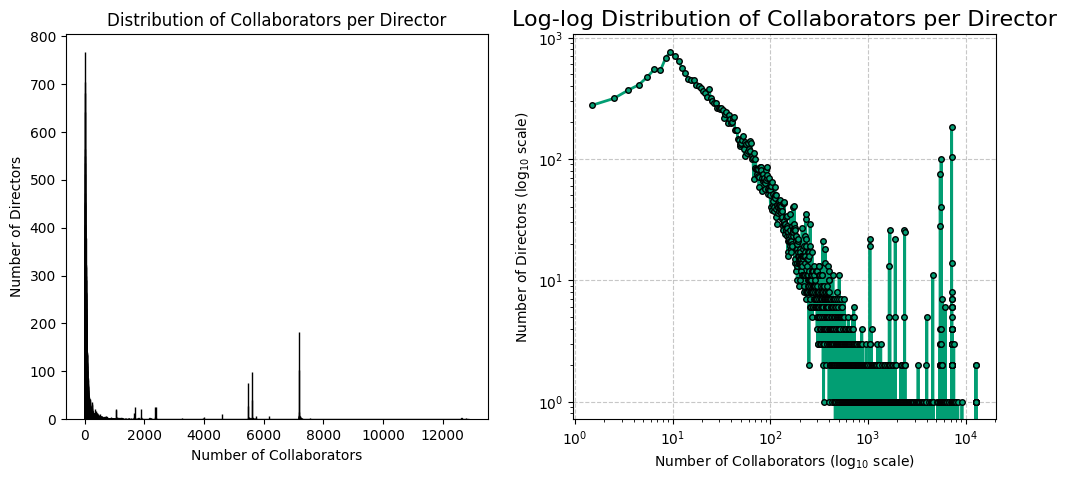

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2), edgecolor='black',color=PALETTE_D[1])
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Directors')
plt.title('Distribution of Collaborators per Director')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Number of Collaborators (log$_{10}$ scale)')
plt.ylabel('Number of Directors (log$_{10}$ scale)')
plt.title('Log-log Distribution of Collaborators per Director', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.tight_layout()
plt.show();

We have a minority of directors that directed a huge number of films and thus had a huge number of collaborations throughout their career.
Let's see if this behaviour reproduces for the size of the movie crew :

```python
def get_movie_crew_size(movies,matched_people) :
    """ 
    Retrieves the movie crew size for selected movies.

    Args : 
        movies : The dataframe containing information about our selected movies,
        matched_people : The IMDb 'basics' dataframe mapped for the people in our selected movies only.

    Returns :
        final_movies : A copy of the 'movies' dataframe passed as argument with an additional column containing the crew size of the movie.
    """
    #Retrieving all roles played by the individuals of the matched_people dataframe, taking the union on both to not count a movie twice
    crew = matched_people.copy()
    crew['knownForTitles'] = crew['knownForTitles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    crew['all_known_roles'] = crew['all_known_roles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    roles_union_df = crew[['knownForTitles', 'all_known_roles']].apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)

    # Appropriate merges to return a modified version of the 'movies' dataframe
    roles_union_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_union_df})
    roles_union_df = roles_union_df.explode('roles_union')
    merged_df = pd.merge(movies, roles_union_df, left_index=True, right_on='roles_union')
    crew_sizes = pd.DataFrame(merged_df.groupby('roles_union')['nconst'].nunique())
    crew_sizes.rename(columns={'nconst': 'crew_size'},inplace=True)
    final_movies = pd.merge(movies,crew_sizes,left_index=True, right_index=True, how='left')

    return final_movies

movies_wcs = get_movie_crew_size(movies,mip_enhanced)
save_parquet_to_generated("q1_movies_wcs", movies_wcs)
```

In [24]:
movies_wcs = read_dataframe_parquet("q1/movies_wcs")

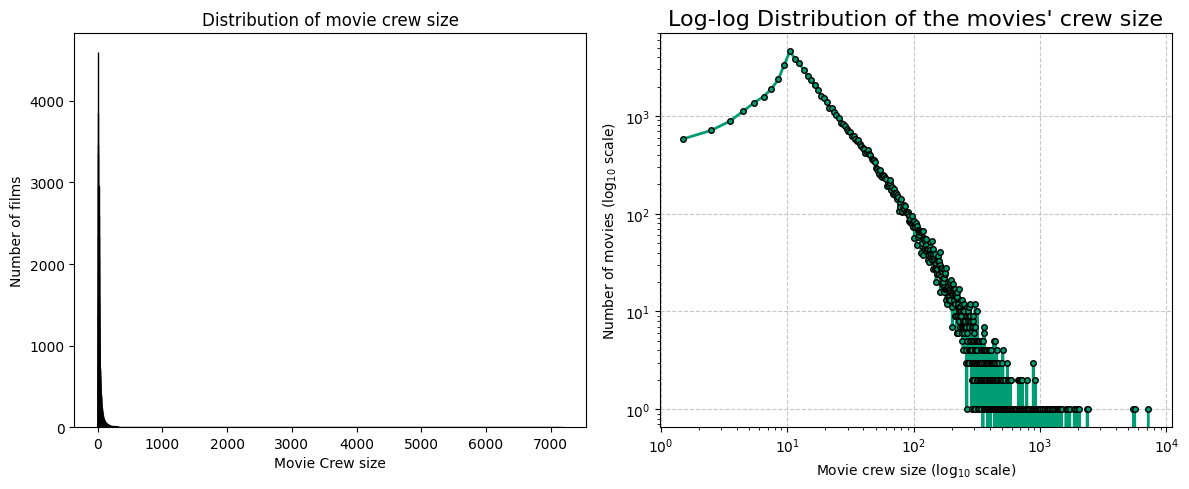

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2), edgecolor='black')
plt.xlabel('Movie Crew size')
plt.ylabel('Number of films')
plt.title('Distribution of movie crew size')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Movie crew size (log$_{10}$ scale)')
plt.ylabel('Number of movies (log$_{10}$ scale)')
plt.title('Log-log Distribution of the movies\' crew size', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

How are our movie scores distributed?

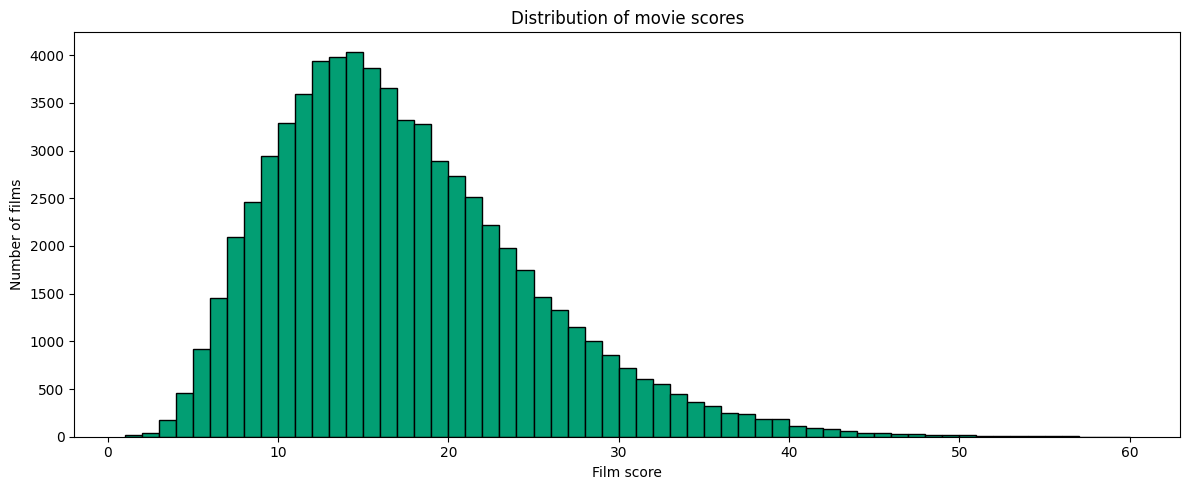

In [26]:
plt.figure(figsize=(12, 5))
plt.hist(movies['score'], bins=range(1, int(max(movies['score'])) + 2), color=PALETTE_D[1], edgecolor='black')
plt.xlabel('Film score')
plt.ylabel('Number of films')
plt.title('Distribution of movie scores')
plt.tight_layout()
plt.show()

Skewed, but not a power law. <br>
Let us thus first see how the movie crew size is linked to the movie score:

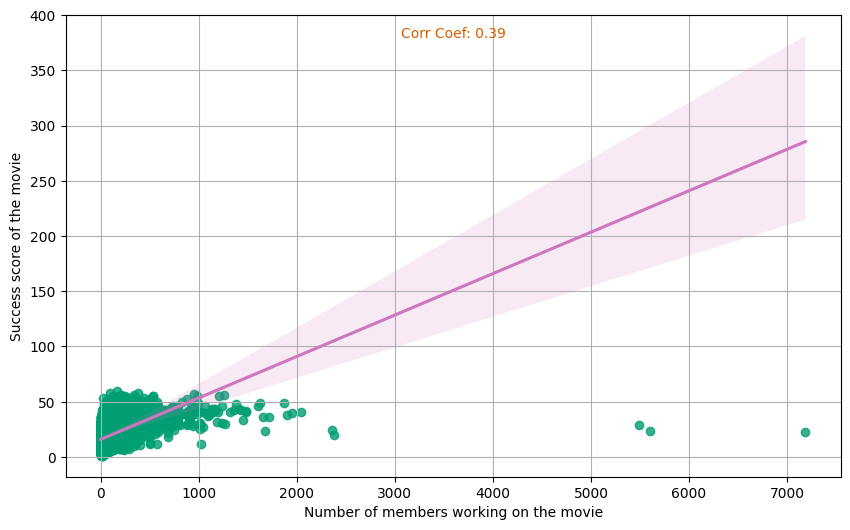

In [27]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wcs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wcs['crew_size'].corr(movies_wcs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

A few number of outliers with huge movie crewsizes : let's remove them to keep some reasonable crew sizes.

In [28]:
movies_wscs = movies_wcs[movies_wcs['crew_size'] < 3000]

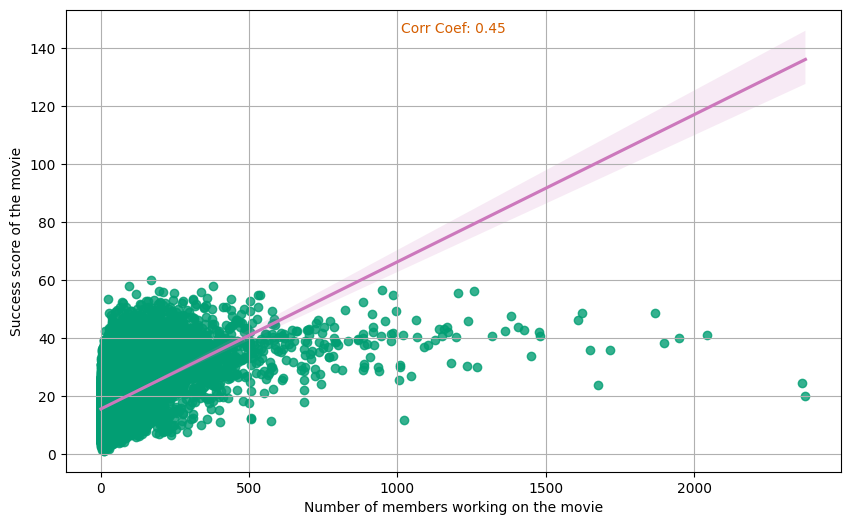

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wscs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wscs['crew_size'].corr(movies_wscs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

Difficult to assess the meaningfulness of the correlation between the size of the movie crew and the score of the movie. Let's display our first 10 movies in terms of score :

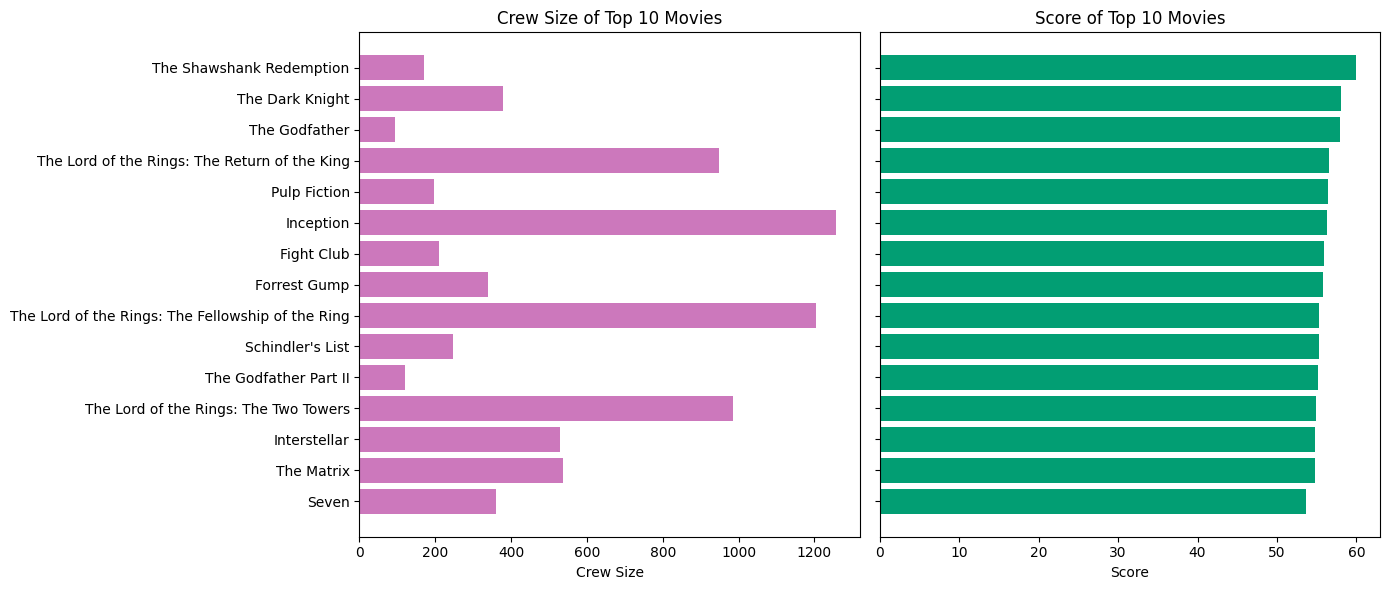

In [30]:
top_10_movies = movies_wscs.sort_values(by='score', ascending=False).head(15)
top_10_movies = top_10_movies.sort_values(by='score', ascending=True)

top_10_movies = top_10_movies.head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot 1: Crew Size
ax1.barh(top_10_movies['title'], top_10_movies['crew_size'], color= PALETTE_D[0])
ax1.set_xlabel('Crew Size')
ax1.set_title('Crew Size of Top 10 Movies')

# Barplot 2: Score
ax2.barh(top_10_movies['title'], top_10_movies['score'], color=PALETTE_D[1])
ax2.set_xlabel('Score')
ax2.set_title('Score of Top 10 Movies')

plt.tight_layout()
plt.show()

We can just see that even amongst our most popular movies, we have the LOTR films & inception with a huge number of people who are credited, but actually the Godfather has a rather small crew size when compared to the latter. <br>
If the impact on a certain movie is thus not really established, Let's try to see how the directors surround themselves for their movies : do they always have a huge number of people around them ?

In [31]:
enhanced_directors_df['directed_movies'] = enhanced_directors_df['directed_movies'].apply(lambda x: ','.join(x))

In [32]:
oui = enhanced_directors_df.copy(deep=True)

oui['directed_movies'] = oui['directed_movies'].apply(lambda x: str(x).split(','))

# Explode the lists to separate rows for each movie ID
directors_exploded = oui.explode('directed_movies')

merged_df = pd.merge(directors_exploded, movies_wcs, how='left', left_on='directed_movies', right_index=True)

# Filter for rows where the director has directed at least 3 movies
filtered_directors = merged_df.groupby('nconst').filter(lambda x: x['directed_movies'].nunique() >= 3)

# Calculate the average crew size for each director
average_crew_size = pd.DataFrame(filtered_directors.groupby('nconst')['crew_size'].mean())

average_crew_size.rename(columns={'crew_size' : 'avg_crew_size'},inplace=True)

enhanced_directors_df = pd.merge(enhanced_directors_df,average_crew_size,how='left',left_index=True,right_index=True)

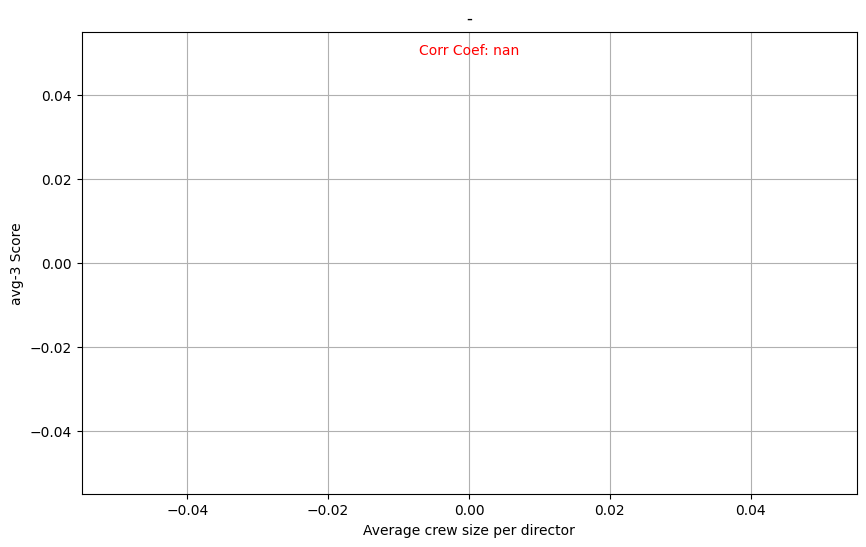

In [33]:
tmp_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3'])
tmp_df[['avg_crew_size', 'avg-3']] = tmp_df[['avg_crew_size', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=tmp_df, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = tmp_df['avg_crew_size'].corr(tmp_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew size per director')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [ ]:
# preloading if u have

### Are the directors who always work with the same crew more successful?

### Are some directors successful only because they cast popular actors?

### Can we find directors that decided to cast, for their next project, only very popular actors by looking at details about their previous work?

### Is directors' success related to the presence of certain individuals in their team ? If yes, how frequently have they been collaborating with each other?

### How are both experience ( i.e how many movies people have directed / worked on etc.) & diversity in their career linked to movie success?

### Several directors = more success?

# Q2: To what extent does the director’s choice of movie genre affect the success of the movie?

In [ ]:
# preloading if u have

### Are more successful directors more often specialized in a certain combination of genres?

### Are directors who tend to work on more diverse projects less successful or more successful?

### Correlation between a director’s critical success and evolution of their style regarding movie genres?

### To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency?

### Is it less likely or more likely for a movie to succeed when the director tries a new genre?

# Q3: What is the impact of the director’s character choices on the success of the movie?

In [ ]:
# preloading if u have

### What types of characters do successful directors choose ? 

### How diverse the directors are in their character choices? 

### Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices?

### In definitive, how does this impact the movie’s success?

### Slight improvement for Identify the characters types: multi character idea

### create a director movie character_type dataframe